In [3]:
import numpy as np
import matplotlib.pyplot as plt
import qutip
from scipy.signal.windows import dpss
from scipy.interpolate import interp1d

Two fixed frequency qubit coupled via tunable coupler ($w_{q1}-w_{q2}=constant$)
(All qubit are assumed as a perfect two level system)
## Let's make iSWAP
$$U_{iSWAP}=\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 0 & -i & 0 \\
0 & -i & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}$$

from $|10>$ state to $|01> $

$$\tilde{H}(t)=g(t) 
\begin{bmatrix}
0 & 0 & 0 & 0\\
0 & 0 & e^{-i\delta \omega_{12}t} & 0 \\
0 & e^{i\delta \omega_{12}t} & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}

-\frac{\Omega_1}{2}V_1S_1(t)
\begin{bmatrix}
0 & 0 & e^{i(\delta \omega_{1d}t + \phi_1)} & 0\\
0 & 0 & 0 & e^{i(\delta \omega_{1d}t + \phi_1)} \\
e^{-i(\delta \omega_{1d}t + \phi_1)} & 0 & 0 & 0 \\
0 & e^{-i(\delta \omega_{1d}t + \phi_1)} & 0 & 0
\end{bmatrix}

-\frac{\Omega_2}{2}V_2S_2(t)
\begin{bmatrix}
0 & e^{i(\delta \omega_{2d}t + \phi_2)}& 0 & 0\\
e^{-i(\delta \omega_{2d}t + \phi_2)} & 0 & 0 & 0 \\
0 & 0 & 0 & e^{i(\delta \omega_{2d}t + \phi_2)}\\
0 & 0 & e^{-i(\delta \omega_{2d}t + \phi_2)} & 0
\end{bmatrix}$$


# Setting

### Rabi oscillation frequency $\Omega$

$\Omega_1/(2\pi)=0.01$(10MHz)
$\Omega_2/(2\pi)=0.01$(10MHz)

### Qubit frequency difference $\delta \omega_{12}$
얘네가 문제임 Z line으로 control 가능하게 해야 realistic 한데

### Detuning $\delta \omega_{1}$, $\delta \omega_{2}$
$\delta \omega=\omega_q -\omega_d$


### g
$g/(2\pi)$=

### Anharmonicty $\eta$
$\eta/(2\pi)=0$ 아직 추가안함





In [4]:
def make_U(H, time_step):
    """
    PARAMETER
        Hamiltonian : function of t
        time_step : float
    RETURNS
        U : function of t
    """
    hbar = 1.
    I = np.identity(4,dtype="complex128")
    
    def U(t):
        total = I #U(t=0)
        check = [I]
        times = np.arange(start=0,stop=t,step=time_step)
        for time in times:
            derivative = (-1j/hbar)*np.matmul(H(time),total)*time_step
            total = total + derivative
            check.append(total) 
        return total, np.array(check)
    return U

In [5]:
def make_H_int(g,delta_omega):
    """
    
    :param g: coupling strength
    :param detuning: omega_q1 - omega_q2
    :return: 
    """
    def H_int(t):
        matrix=np.zeros((4,4),dtype="complex128")
        matrix[2][1] = np.exp((1j)*delta_omega*t)
        matrix[1][2] = np.exp((-1j)*delta_omega*t)
        return g(t)*matrix
    return H_int

In [6]:
def make_H_d1(Omega,V_0,delta_omega,phi,s):
    """
    :param Omega:  
    :param V_0: 
    :param delta_omega:omega_q - omega_d 
    :param phi: offset in driving sine wave
    :param s: control pulse
    :return: 
    """
    I=np.identity(2,dtype=complex)

    def H(t):
        matrix=np.zeros((2,2),dtype=complex)
        matrix[0][1]=np.exp((1j)*(delta_omega*t+phi))
        matrix[1][0]=np.exp((-1j)*(delta_omega*t+phi))
    
        return (-0.5)*Omega*V_0*s(t)*np.kron(matrix,I)
    
    return H #4by4 matrix

In [8]:
def make_H_d2(Omega,V_0,delta_omega,phi,s):
    """
    :param Omega:  
    :param V_0: 
    :param delta_omega:omega_q - omega_d 
    :param phi: offset in driving sine wave
    :param s: control pulse
    :return: 
    """
    I=np.identity(2,dtype=complex)
    
    def H(t):
        matrix=np.zeros((2,2),dtype='complex128')
        matrix[0][1]=np.exp((1j)*(delta_omega*t+phi))
        matrix[1][0]=np.exp((-1j)*(delta_omega*t+phi))
    
        return (-0.5)*Omega*V_0*s(t)*np.kron(I,matrix)
    
    return H #4by4 matrix

In [9]:
def g(t):
    return 0.04*2*np.pi 
# 40MHz

In [10]:
def slepian(t):
    Fs = 10 #sampling rate 1ns에 10번 
    N = 500
    time = np.arange(N+1)/Fs 
    #freq = np.fft.fftfreq(N+1,d=1/Fs)
    NW = 6    # Time-halfbandwidth product
    # Generating the Slepian sequences
    slepian_sequence = dpss(N+1, NW)
    slepian_continuous = interp1d(time, slepian_sequence, kind='cubic')
    return slepian_continuous(t)

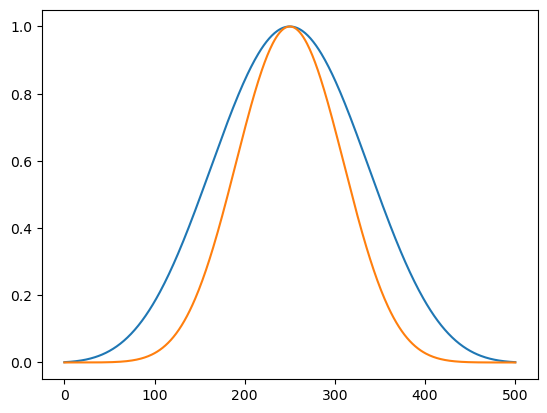

In [11]:
Fs = 10 #sampling rate 1ns에 10번 
N = 500
time = np.arange(N+1)/Fs 
    #freq = np.fft.fftfreq(N+1,d=1/Fs)
NW =  3   # Time-halfbandwidth product
    # Generating the Slepian sequences
slepian_sequence = dpss(N+1, NW)
slepian_sequence2 = dpss(N+1, 6)
fig, ax = plt.subplots()
ax.plot(slepian_sequence)
ax.plot(slepian_sequence2)

In [18]:
len(slepian_sequence2)

501

In [12]:
#Setting
omega1 = 0.01 * 2 * np.pi #10MHz
omega2 = 0.01 * 2 * np.pi #10MHz
V1=1.
V2=1. #unit?
delta_omega1 = 0.001 * 2 * np.pi #1MHz #qubit frequency and driving frequency
delta_omega2 = 0.001 * 2 * np.pi #1MHz
delta_q12 = 1 * 2 * np.pi # 1GHz
phi1 = 0.001
phi2 = 0.001

In [13]:
H_int = make_H_int(g=g,delta_omega=delta_omega2) 
H_d1 = make_H_d1(Omega=omega1, V_0=V1,delta_omega=delta_omega1,s=slepian,phi=phi1)
H_d2 = make_H_d2(Omega=omega2, V_0=V2,delta_omega=delta_omega2,s=slepian,phi=phi2)
def H(t):
    return H_int(t)+H_d1(t)+H_d2(t)

In [14]:
U = make_U(H, time_step=1e-4)

In [15]:
Uhigh = make_U(H, time_step=1e-5)

In [16]:
transition, info = U(50.) #한번 돌리는데 4분30초...GPU로 계산하면 더 빠른가?

In [123]:
transition2, info2 = Uhigh(50.) #47분 미쳤네 

In [1]:
trajectories=[]
fig, ax = plt.subplots()
ax.plot(np.arange(start=0,stop=50.+1e-4,step=1e-4),[u[1,1] for u in info])
ax.plot(np.arange(start=0,stop=50.+1e-5,step=1e-5),[u[1,1] for u in info2])

NameError: name 'plt' is not defined

In [54]:
unitary_check=np.matmul(np.matrix.getH(transition),transition)
unitary_check

array([[ 1.00000205e+00-2.33624112e-18j, -7.89686301e-06-2.84021164e-07j,
        -8.19612484e-06-8.00439925e-09j,  1.97198116e-06+7.30184510e-08j],
       [-7.89686301e-06+2.84021164e-07j,  1.00006516e+00-4.24847323e-18j,
         1.97271103e-06+6.33177438e-08j, -7.59615085e-06+1.75866218e-08j],
       [-8.19612484e-06+8.00439925e-09j,  1.97271103e-06-6.33177438e-08j,
         1.00006512e+00-2.18593786e-18j, -7.87922634e-06-2.83932281e-07j],
       [ 1.97198116e-06-7.30184510e-08j, -7.59615085e-06-1.75866218e-08j,
        -7.87922634e-06+2.83932281e-07j,  1.00000190e+00-3.48172935e-19j]])

In [55]:
#prepare qubit 1 in e 
initial_state = np.array([0,0,1.,0,], dtype=complex)
desired_state = np.array([0,1.,0,0,], dtype=complex)

iSWAP=np.zeros((4,4),dtype=complex)
iSWAP[0,0]=1.
iSWAP[3,3]=1.
iSWAP[2,1]=-1j
iSWAP[1,2]=-1j


In [56]:
trans_state=np.matmul(iSWAP,initial_state)
np.matmul(np.matrix.getH(desired_state),trans_state)

-1j

$$s_1(t),\ s_2(t), g(t)$$



In [57]:
np.matrix.getH(desired_state)

array([0.-0.j, 1.-0.j, 0.-0.j, 0.-0.j])

In [58]:
trans_state

array([0.+0.j, 0.-1.j, 0.+0.j, 0.+0.j])